# Capstone 1 Group 4 Notebook

## Business Understanding

* **Stakeholders** - Computing Vision is a new entrant into the movie studio space.
* **Problem** - Computing Vision wishes to launch original movies in a well-established field and needs recommendations on what to make.
* **Project Value** - We will attempt to find the best genres and production budgets to succeed in the film industry and recommend these findings to Computing Vision.

## Importing necessary libraries

In [31]:
# 3rd party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline

# standard library
import sqlite3
import math

## Loading data

In [32]:
tn_movie_budgets = pd.read_csv('./data/tn.movie_budgets.csv')
tmdb_csv = pd.read_csv('./data/tmdb.movies.csv')

conn = sqlite3.connect('./data/im.db')

Sqlite_df = pd.read_sql("""
select *
from movie_basics
join movie_ratings
using (movie_id)
join movie_akas
using (movie_id)
group by primary_title
;
""", conn)

## Cleaning

### Converting genre IDs to genre names

In [33]:
# Creating dictionary to turn genre IDs into genres
comment = """Action          28
Adventure       12
Animation       16
Comedy          35
Crime           80
Documentary     99
Drama           18
Family          10751
Fantasy         14
History         36
Horror          27
Music           10402
Mystery         9648
Romance         10749
Science Fiction 878
TV Movie        10770
Thriller        53
War             10752
Western         37"""
id_to_genre = {line.split(' ')[-1]:' '.join(line.split(' ')[:-1]).strip() for line in comment.split('\n')}

# Creating function to transform genre IDs
def convert_ids(line):
    return ', '.join(sorted([id_to_genre.get(x.strip(), x.strip()) for x in line[1:-1].split(',')]))

# Transforming and further cleaning genre IDs
Sqlite_df['title'] = Sqlite_df.title.str.lower()

tmdb_csv['genre'] = tmdb_csv.genre_ids.apply(convert_ids)
tmdb_csv.drop(columns=["Unnamed: 0", 'id'], inplace=True)
tmdb_csv['release_date'] = pd.to_datetime(tmdb_csv['release_date'])
tmdb_csv['title'] = tmdb_csv['title'].str.lower()

#Cleaning tn movie budget data
tn_movie_budgets.drop(columns=['id'], inplace=True)
tn_movie_budgets['movie'] = tn_movie_budgets['movie'].str.lower()
tn_movie_budgets['release_date'] = pd.to_datetime(tn_movie_budgets['release_date'])
tn_movie_budgets['worldwide_gross'] = tn_movie_budgets['worldwide_gross'].str.lstrip('$').str.replace(',', '').astype(np.int64)
tn_movie_budgets['production_budget'] = tn_movie_budgets['production_budget'].str.lstrip('$').str.replace(',', '').astype(np.int64)
non_zero = tn_movie_budgets[(tn_movie_budgets['worldwide_gross'] > 0) & (tn_movie_budgets['production_budget'] > 0)].copy()
non_zero['profit'] = non_zero['worldwide_gross'] - non_zero['production_budget']
non_zero['profit_on_budget'] = (non_zero['profit'] / non_zero['production_budget']) * 100
non_zero.sort_values(by=['profit_on_budget'], ascending=False, inplace=True)

#Merging both datasets
tmdb_csv = tmdb_csv.merge(Sqlite_df, on='title', how='left')
budget_genre = non_zero.merge(tmdb_csv, left_on=['movie', 'release_date'], right_on=['title', 'release_date'], how='inner').drop_duplicates()

## Create visualizations of profit over production budget by genres

### Create custom color palette and set context

In [34]:
# https://stackoverflow.com/questions/36271302/changing-color-scale-in-seaborn-bar-plot
# https://seaborn.pydata.org/generated/seaborn.color_palette.html
custom_palette = 'blend:#046A38,#86BC25'

def colors_from_values(values, palette_name=custom_palette):
    # normalize the values to range [0, 1]
    normalized = (values - np.min(values)) / (np.max(values) - np.min(values))
    # convert to indices
    indices = np.round((1 - normalized) * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

In [35]:
# set theme and context
sns.set_theme(style="whitegrid")
sns.set_context('poster', rc={'patch.linewidth': 0.6})

### Grouping genres

In [36]:
# we need several movies of each genre before we can classify it as distinct and prevents a one-off genre
at_least_10_in_genre = budget_genre.groupby('genre').filter(lambda x: len(x) >= 10)
at_least_10_in_genre.groupby('genre')['profit_on_budget'].describe()
# we want to group by similar genres and medians
# would like to figure out hierarchical clustering on the genre_ids but would take too long

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
"Action, Adventure, Fantasy",16.0,253.028273,161.022291,-29.604297,163.130391,225.432001,289.810413,616.809150
"Action, Adventure, Fantasy, Science Fiction",11.0,239.881547,186.080319,-0.830889,103.172636,204.796374,291.936774,574.129112
"Action, Adventure, Science Fiction",32.0,235.570714,192.467314,-54.369200,75.722182,194.708093,356.039351,668.101646
"Action, Comedy",14.0,116.004372,150.306836,-69.289036,37.743279,75.673679,158.699574,514.935200
"Action, Comedy, Crime",11.0,140.310178,185.951231,-13.816140,40.798950,70.261803,137.245285,562.667752
"Action, Crime, Drama, Thriller",14.0,118.082674,158.965801,-90.098383,-10.520094,77.119830,245.262518,442.386200
"Action, Crime, Thriller",26.0,77.858534,181.162041,-91.483595,-56.350483,10.168497,162.163910,699.327786
"Action, Science Fiction, Thriller",11.0,181.445684,205.236444,-99.894400,35.000375,120.796009,390.425216,468.221350
"Action, Thriller",20.0,214.457720,230.440367,-81.278432,111.824321,154.540124,234.730970,756.890320


In [37]:
# manually map the groups
def consolidate_genre(genre_list):
    if genre_list.startswith('Action, Adventure'):
        return 'Action, Adventure'
    elif genre_list.startswith('Action, Comedy'):
        return 'Action, Comedy'
    elif genre_list == 'Action, Crime, Thriller' or genre_list == 'Crime, Drama, Thriller':
        return 'Crime, Thriller'
    elif (genre_list.startswith('Action') and genre_list.endswith('Thriller')) or genre_list == 'Drama, Thriller':
        return 'Thriller'
    elif genre_list.startswith('Adventure, Animation'):
        return 'Adventure, Animation'
    elif genre_list.startswith('Comedy'):
        return 'Comedy, Other'
    elif genre_list == 'Drama, Mystery, Thriller':
        return 'Drama, Mystery, Thriller'
    elif genre_list == 'Drama, Romance':
        return 'Drama, Romance'
    elif 'Drama' in genre_list:
        return 'Drama, Other'
    elif genre_list.startswith('Horror'):
        return 'Horror, Other'
    else:
        return genre_list

In [38]:
# consolidate the genres
at_least_10_in_genre['consolidated_genre'] = at_least_10_in_genre['genre'].apply(consolidate_genre)

### Top profit over production budget (POPB) by genres

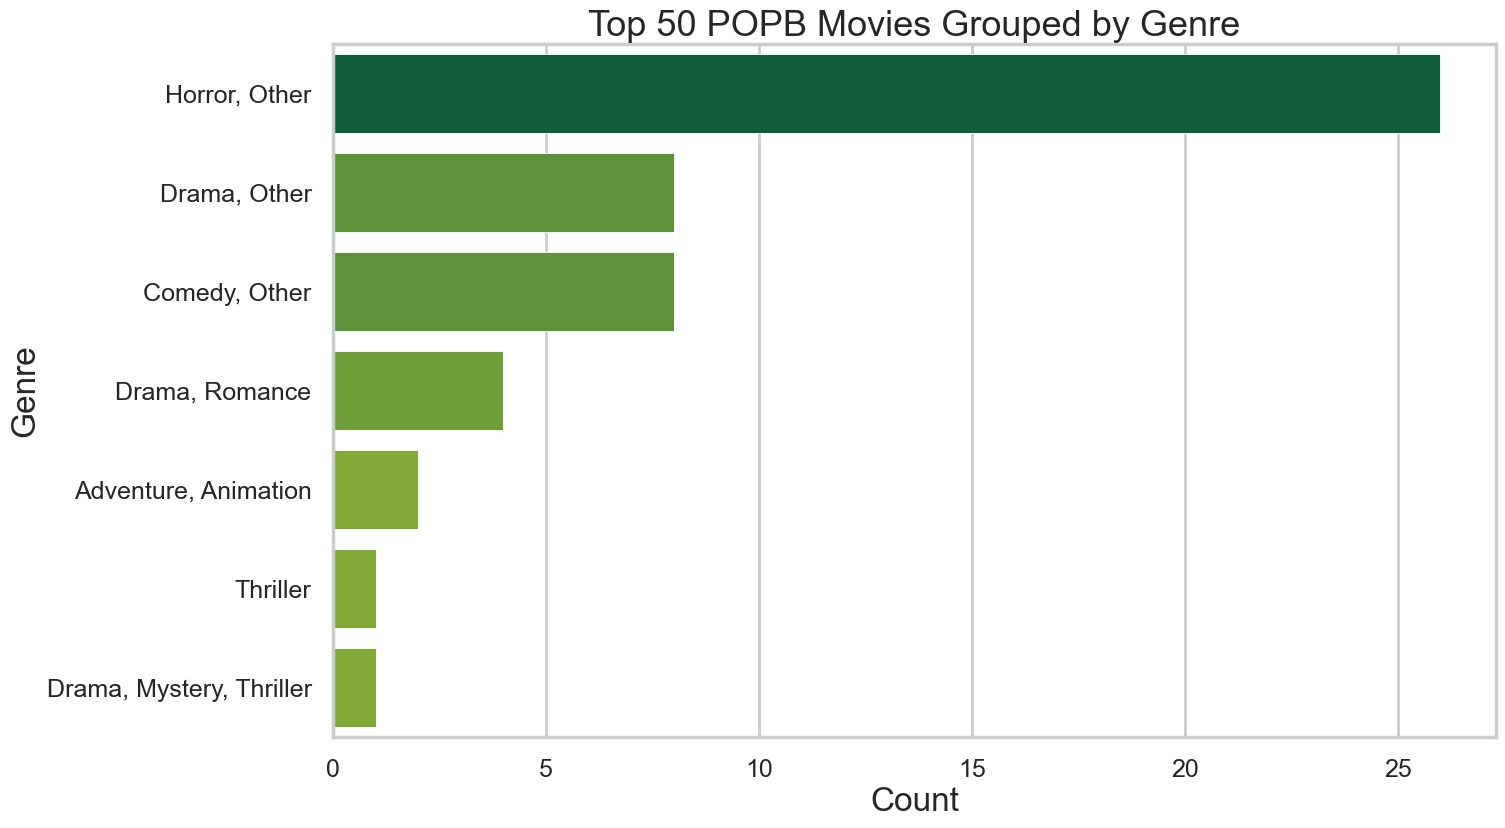

In [39]:
# grab the top 50 return on budget movies and count the genres
genre_combined = at_least_10_in_genre.iloc[:50]['consolidated_genre'].value_counts()
genre_combined_df = genre_combined.reset_index()
genre_combined_df.columns = ['genre', 'count']

plt.figure(figsize=(15,9))
sns.barplot(data=genre_combined_df.iloc[:8], x='count', y='genre', orient='h', palette=colors_from_values(genre_combined_df['count']))
plt.title('Top 50 POPB Movies Grouped by Genre', fontsize=26)
plt.xlabel('Count', fontsize=24)
plt.ylabel('Genre', fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
#plt.savefig('images/top_POPB.svg', format='svg', bbox_inches='tight')
None

### Median POPB grouped by genres

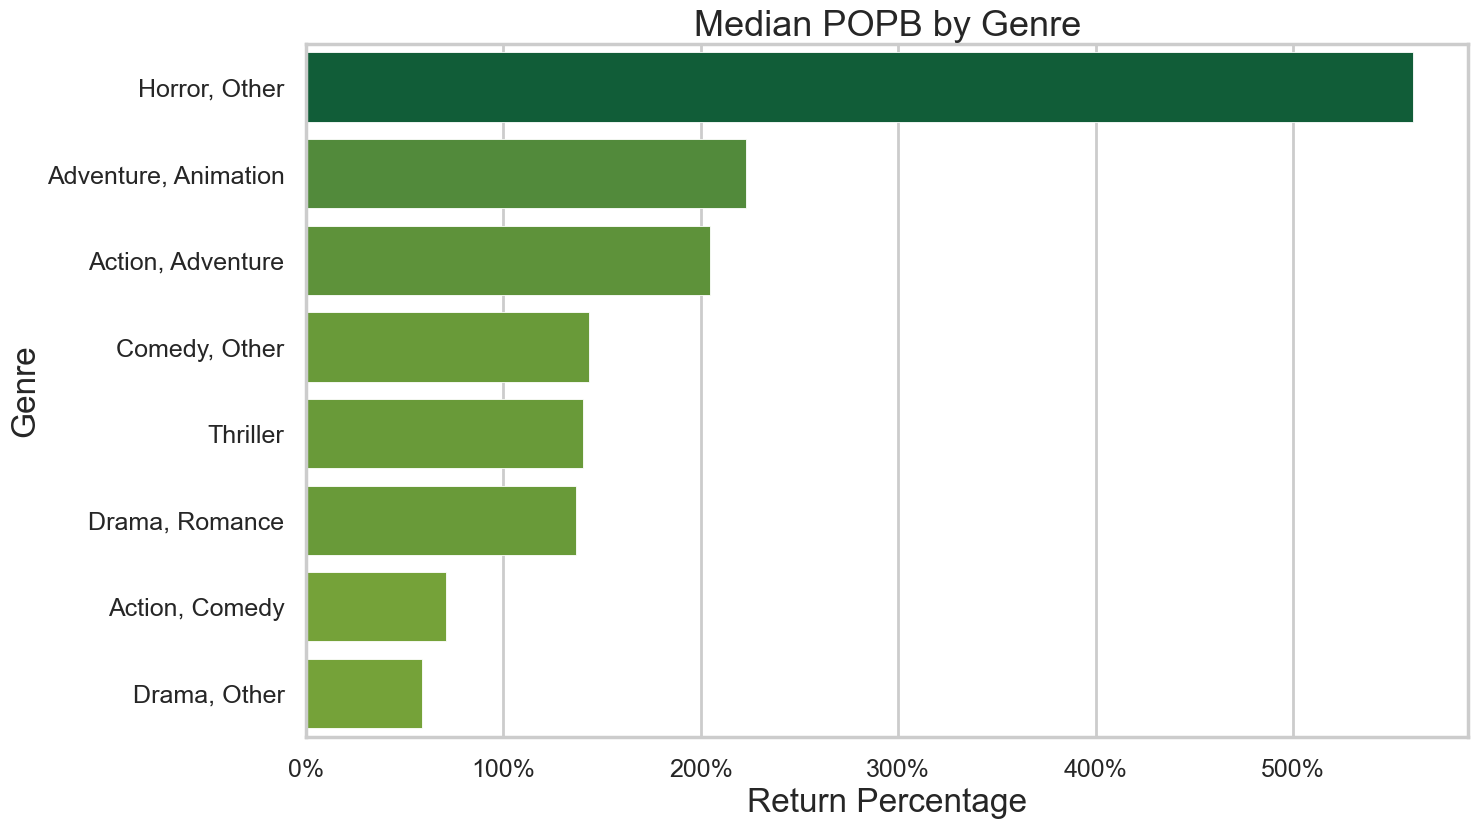

In [40]:
# get the median profit over production budget
median_genre = at_least_10_in_genre.groupby('consolidated_genre')['profit_on_budget'].median().sort_values(ascending=False)
median_genre_df = median_genre.reset_index()
median_genre_df.columns = ['genre', 'median profit over budget']

# plot 
plt.figure(figsize=(15,9))
sns.barplot(data=median_genre_df.iloc[:8], x='median profit over budget', y='genre', palette=colors_from_values(median_genre_df['median profit over budget']), orient='h')
plt.title('Median POPB by Genre', fontsize=26)
plt.xlabel('Return Percentage', fontsize=24)
plt.ylabel('Genre', fontsize=24)
plt.yticks(fontsize=18)
plt.xticks(ticks=[0, 100, 200, 300, 400, 500], labels=['0%', '100%', '200%', '300%', '400%', '500%'], fontsize=18)
#plt.savefig('images/median_POPB.svg', format='svg', bbox_inches='tight')
None

## Boxplots of production budget by genres

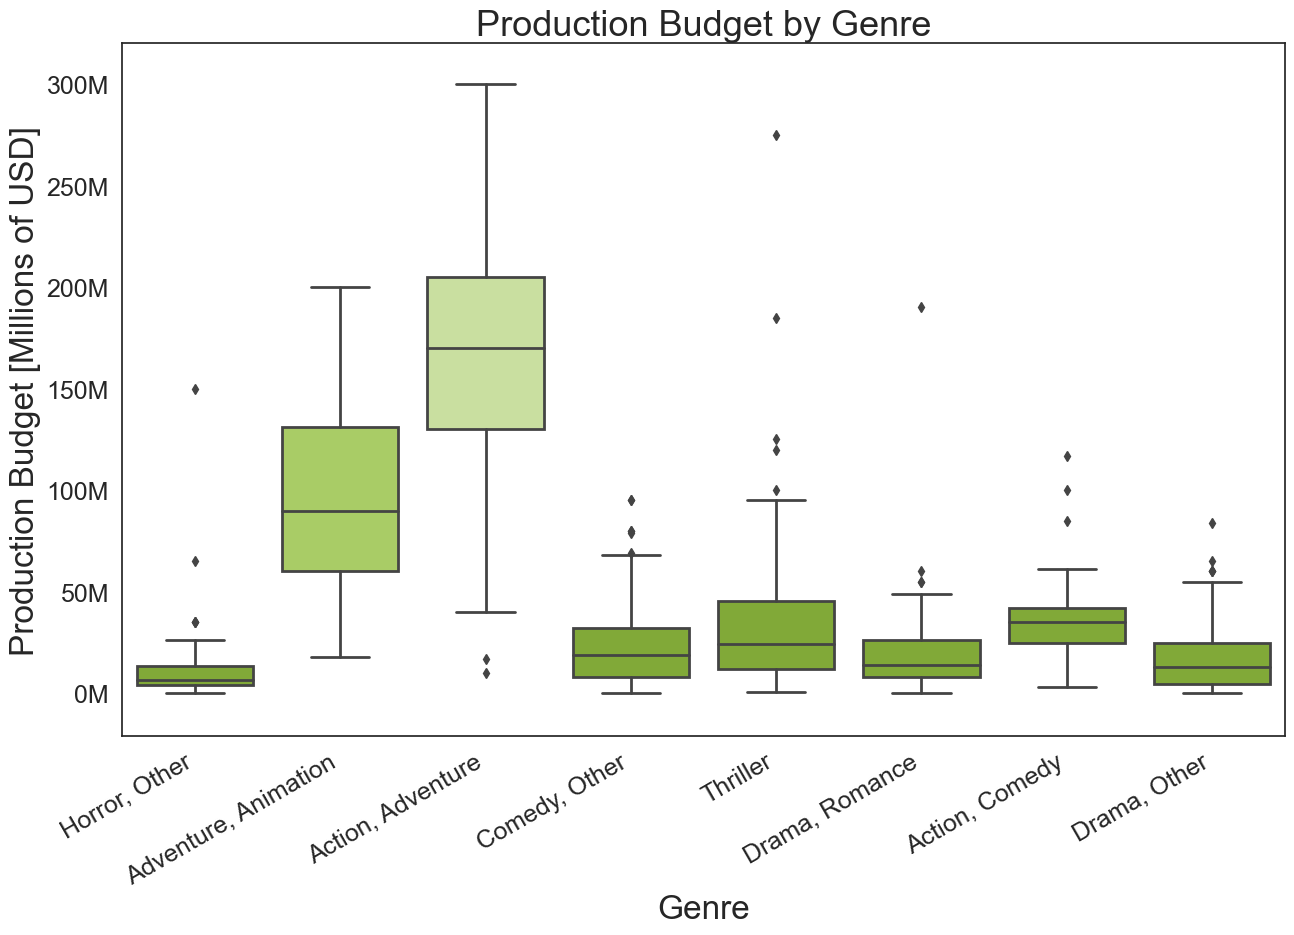

In [41]:
sns.set_theme(style="white")

plt.figure(figsize=(15,9))
color_map = {genre: '#aedd55' if genre == 'Adventure, Animation' else '#ccea95' if genre == 'Action, Adventure' else '#86BC25' for genre in median_genre.index[:-2]}
sns.boxplot(data=at_least_10_in_genre, x='consolidated_genre', y='production_budget', order=median_genre.index[:-2], linewidth=2, palette=color_map)
plt.title('Production Budget by Genre', fontsize=26)
plt.ylabel('Production Budget [Millions of USD]', fontsize=24)
plt.xlabel('Genre', fontsize=24)
plt.ylim(top=320_000_000)
plt.yticks(ticks=[0, 50_000_000, 100_000_000, 150_000_000, 200_000_000, 250_000_000, 300_000_000], labels=['0M', '50M', '100M', '150M', '200M', '250M', '300M'], fontsize=18)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=18)
#plt.savefig('images/PB_distribution.svg', format='svg', bbox_inches='tight')

sns.set_theme(style="whitegrid")
sns.set_context('poster', rc={'patch.linewidth': 0.6})

## Top combined genres profit

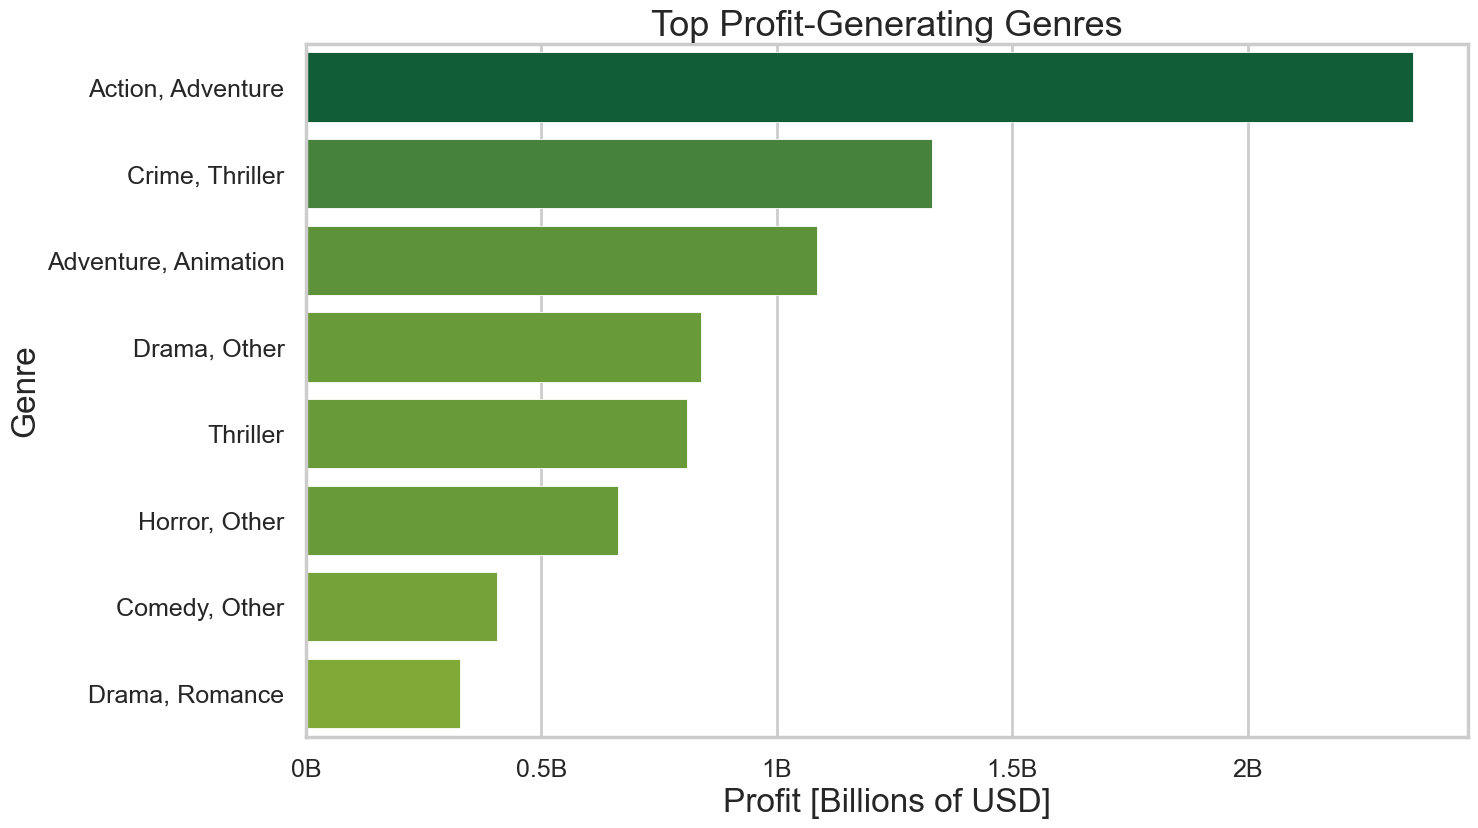

In [42]:
# get the maximum profit movie from each genre
max_profit_genre = at_least_10_in_genre.groupby('consolidated_genre')['profit'].max().sort_values(ascending=False)
max_profit_genre_df = max_profit_genre.reset_index()
max_profit_genre_df.columns = ['genre', 'profit']

plt.figure(figsize=(15,9))
sns.barplot(data=max_profit_genre_df.iloc[:8], y='genre', x='profit', palette=colors_from_values(max_profit_genre_df['profit']))#, errorbar=None);

plt.title('Top Profit-Generating Genres', fontsize=26)
plt.xticks(ticks=[0, 500_000_000, 1_000_000_000, 1_500_000_000, 2_000_000_000], labels=['0B', '0.5B', '1B', '1.5B', '2B'], fontsize=18);
plt.yticks(fontsize=18);
plt.xlabel('Profit [Billions of USD]', fontsize=24);
plt.ylabel('Genre', fontsize=24);
plt.savefig('images/consolidated_genre_top_profit.svg', format='svg', bbox_inches='tight')
None

## Analyzing correlation between production budget and worldwide profit

In [44]:
budget_genre['worldwide profit'] = budget_genre['worldwide_gross'].fillna(0).astype('int64') - budget_genre['production_budget'].fillna(0).astype('int64')

prod_bud_cor = budget_genre.production_budget.fillna(budget_genre.production_budget.mean())
world_prof_cor = budget_genre['worldwide profit'].fillna(budget_genre['worldwide profit'].mean())

cor_value = prod_bud_cor.astype('int64').corr(world_prof_cor.astype('int64'))
cor_value_strength = None
if cor_value >= .5:
    cor_value_strength = 'strong'
elif cor_value >= .3:
    cor_value_strength = 'moderate'
else:
    cor_value_strength = 'weak'
    

print(f'There is a {cor_value_strength} correlation between the production budget and worldwide profit with a value of {round(cor_value, 4)}.')

There is a strong correlation between the production budget and worldwide profit with a value of 0.6807.


## Determining 95% confidence interval for production budget

In [45]:
prod_budget_std = budget_genre_sorted.iloc[:100].production_budget.astype('int64').std()
prod_budget_mean = budget_genre_sorted.iloc[:100].production_budget.astype('int64').mean()


x_hat = prod_budget_mean
z = stats.norm.ppf(q=.95)
pop_stdev = budget_genre.production_budget.dropna().astype('int64').std()
sample_size = len(budget_genre_sorted.iloc[:100])
moe = (z * pop_stdev)/(math.sqrt(sample_size))
conf = (round(x_hat - moe, 2), round(x_hat + moe, 2))
print(f'We are 95% confident that the true mean of production budgets of the top 10 profiting movies is contained within the range ${round(conf[0], 2)} and ${round(conf[1], 2)}. Further, due to the {cor_value_strength} correlation between profit and production budgets of {round(cor_value, 4)} we \nrecommend that the production budget for a new movie should be within this range.')

We are 95% confident that the true mean of production budgets of the top 10 profiting movies is contained within the range $149880980.81 and $168523019.19. Further, due to the strong correlation between profit and production budgets of 0.6807 we 
recommend that the production budget for a new movie should be within this range.


## Closing connection

In [ ]:
conn.close()

## Conclusion and Three Recommendations

**From our analysis, we have three key recommendations to steer Computing Vision's future towards profitability.**

<ol>
    <li>Maximizing Return on Production:</li>
        <ul>
            <li>Recommendation: Consider producing movies in the Horror genre.</li>
            <li>Rationale: This genre has had substantial return on production investment.</li>
        </ul>
    <li>Achieving Overall Best Profitability:</li>
        <ul>
            <li>Recommendation: Prioritize the creation of movies in the Action &amp; Adventure genre.</li>
            <li>Rationale: Action &amp; Adventure has the potential to make the highest overall profit.</li>
        </ul>
    <li>Optimizing Production Budget:</li>
        <ul>
            <li>Recommendation: Maintain production budgets within the range of \$149,880,980.81 to \$168,523,019.19.</li>
            <li>Rationale: This budget range balances investment, in quality production, with favorable returns.</li>
        </ul>
</ol>